# Load all the raw documents, combined from all the subreddits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/FYP/Data/Annotation Data/documents-all-raw.csv",lineterminator='\n')
df

,document,subreddit
0,If the last five years of television should ha...,television
1,The title says it all. I'm a bit miffed but a...,television
2,Robert Englund played the lovable I-can't-beli...,television
3,Hope it's OK to ask here...\n\nI changed from ...,television
4,you get 3 hrs/day during the week and 1 hr on ...,television
...,...,...
589563,I made a similar post earlier in r/askmuslims ...,islam
589564,"Salam, the title is pretty self explanatory, b...",islam
589565,This is more of an emotional rather than a rat...,islam
589566,"salaam,\n\nmy father died last year and my mom...",islam


# Longer documents would be harder to read and annotate.
### We will filter out any documents longer than the upper limit(vast majority of documents will be smaller than this) of document length(in characters).
---
### Results: Upperlimit was 2790.5 ≈ 2791 chars, so we will not use any documents longer than 2791 chars.
note: We set a lowerlimit of 500 chars ourselves, when collecting the data.

In [ ]:
df["document_length"]=df["document"].str.len()
df

,document,subreddit,document_length
0,If the last five years of television should ha...,television,1019
1,The title says it all. I'm a bit miffed but a...,television,776
2,Robert Englund played the lovable I-can't-beli...,television,887
3,Hope it's OK to ask here...\n\nI changed from ...,television,1533
4,you get 3 hrs/day during the week and 1 hr on ...,television,537
...,...,...,...
589563,I made a similar post earlier in r/askmuslims ...,islam,836
589564,"Salam, the title is pretty self explanatory, b...",islam,851
589565,This is more of an emotional rather than a rat...,islam,2066
589566,"salaam,\n\nmy father died last year and my mom...",islam,703


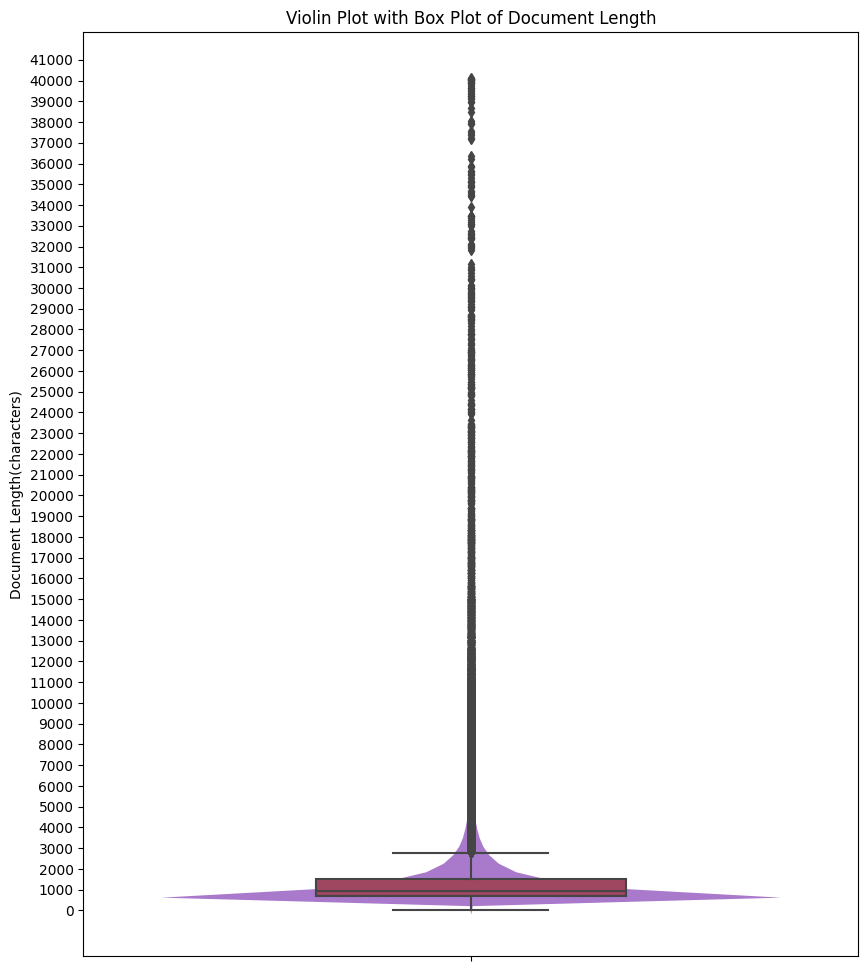

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

ax = sns.violinplot(data=df, y='document_length', color="#af52f4", inner=None, linewidth=0, saturation=0.5)
sns.boxplot(data=df, y='document_length', saturation=0.5, width=0.4,
            palette='rocket', boxprops={'zorder': 2}, ax=ax)

plt.ylabel("Document Length(characters)")

# plt.locator_params(axis='y', nbins=48)
y_ticks = range(0, int(round(ax.get_ylim()[1],-3)), 1000)
plt.yticks(y_ticks)

plt.title("Violin Plot with Box Plot of Document Length")
plt.show()

In [ ]:
# Calculate Boxplot stats
Q1 = df['document_length'].quantile(0.25)
Q2 = df['document_length'].quantile(0.50)
Q3 = df['document_length'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

print(f"Upper Limit: {upper}")
print(f"Q3 (75th Percentile): {Q3}")
print(f"Q2 (50th Percentile/Median): {Q2}")
print(f"Q1 (25th Percentile): {Q1}")

Upper Limit: 2790.5
Q3 (75th Percentile): 1520.0
Q2 (50th Percentile/Median): 948.0
Q1 (25th Percentile): 673.0


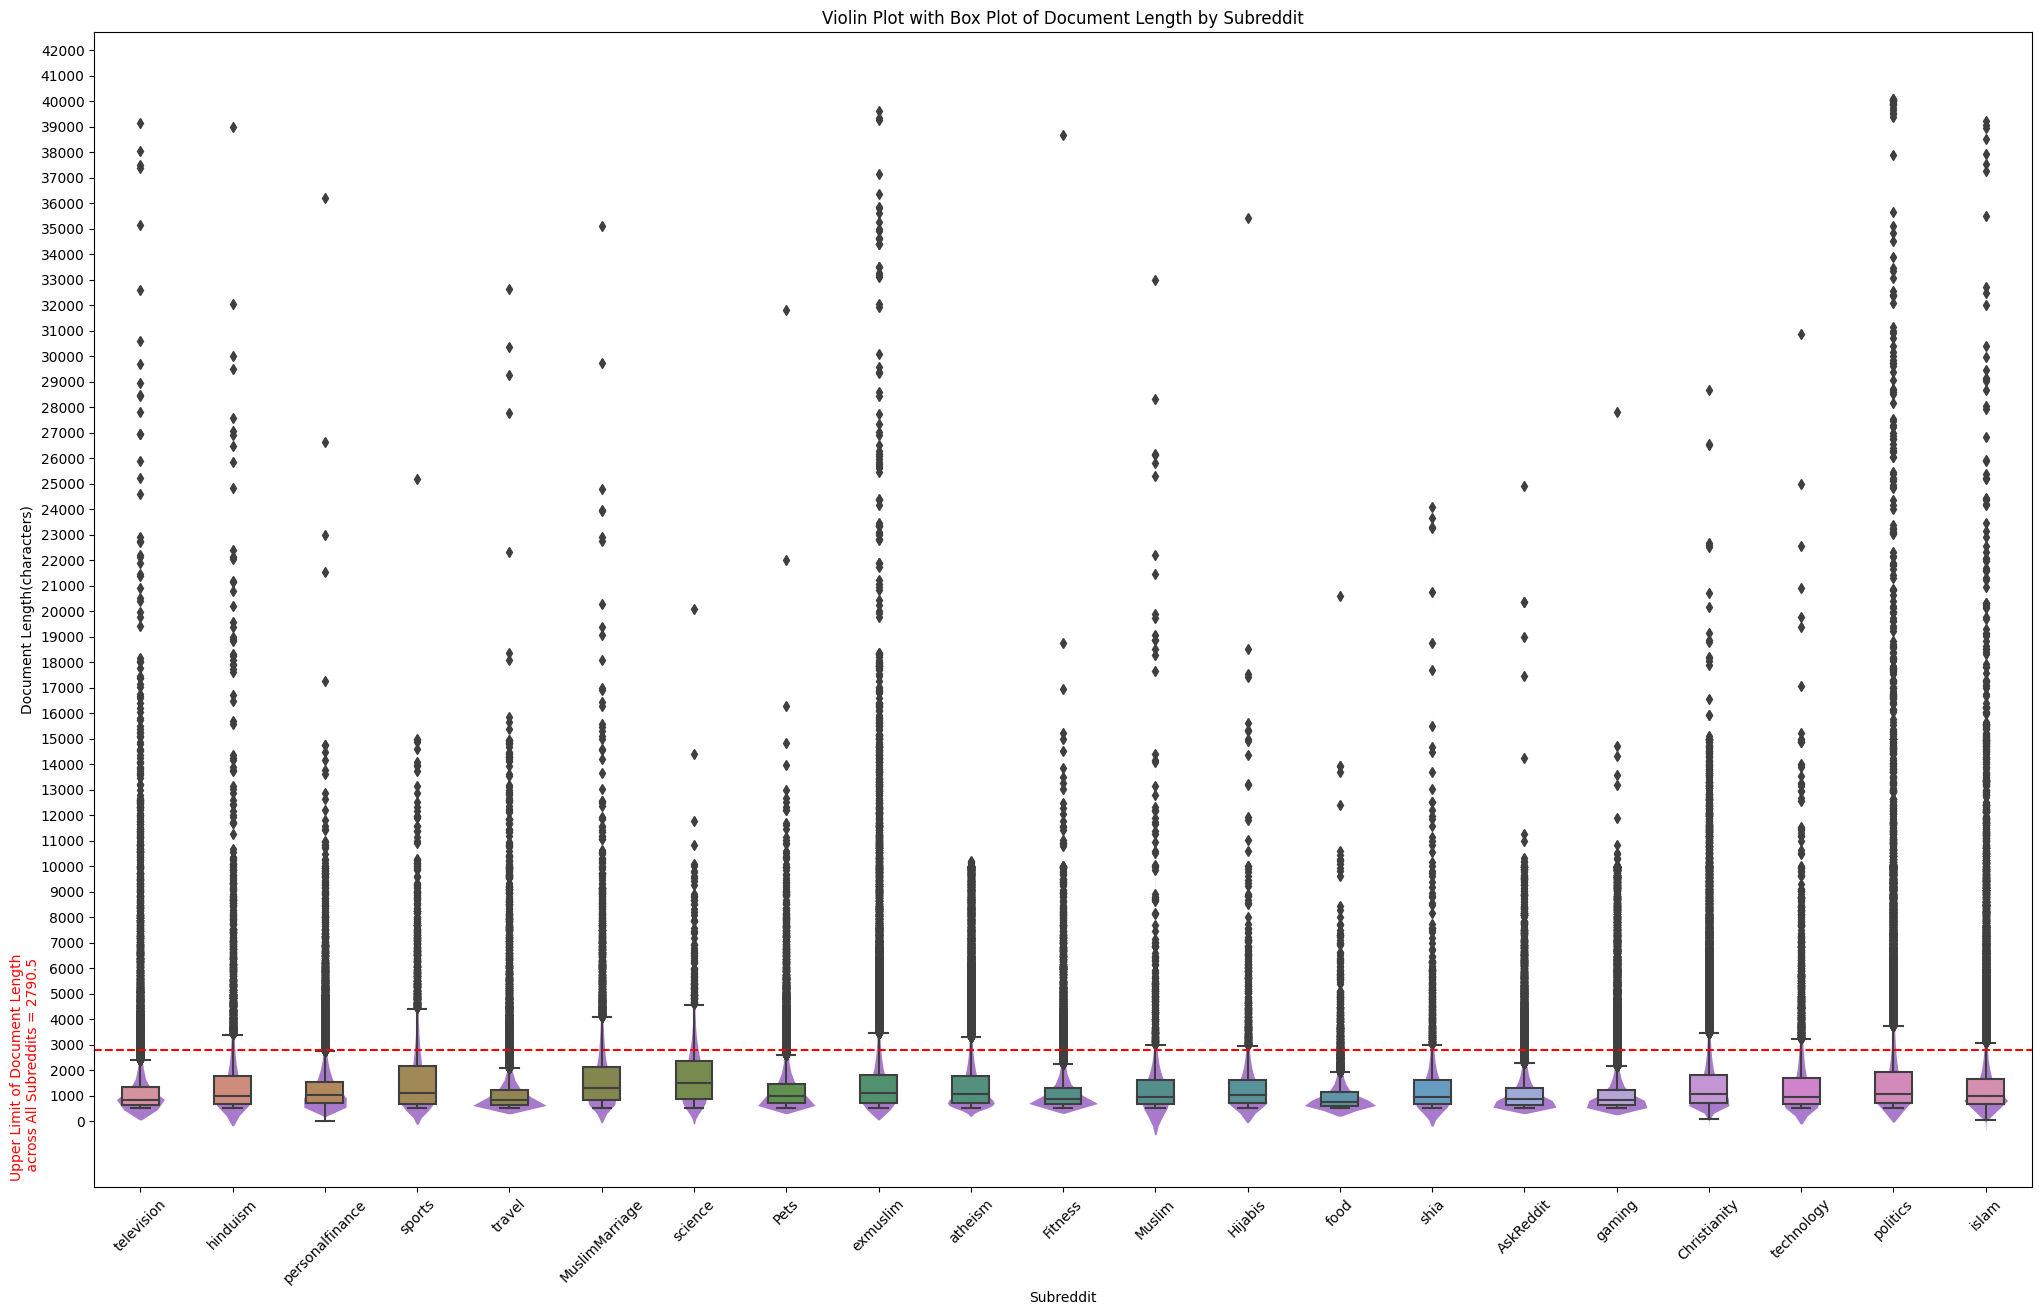

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a "document_length" column and a "subreddit" column
plt.figure(figsize=(25, 15))

ax = sns.violinplot(data=df, x='subreddit', y='document_length', color="#af52f4", inner=None, linewidth=0, saturation=0.5)
sns.boxplot(data=df, x='subreddit', y='document_length', saturation=0.5, width=0.4,
            palette='husl', boxprops={'zorder': 2}, ax=ax)

plt.xlabel("Subreddit")
plt.ylabel("Document Length(characters)")
plt.title("Violin Plot with Box Plot of Document Length by Subreddit")

y_value = upper
plt.axhline(y=y_value, color='red', linestyle='--')
plt.text(-1.25, y_value-5000, f'Upper Limit of Document Length\n across All Subreddits = {y_value}', color='red', fontsize=10, rotation='vertical', ha="center")

y_ticks = range(0, int(round(ax.get_ylim()[1],-3)), 1000)
plt.yticks(y_ticks)
plt.xticks(rotation=45)

plt.show()

# Quality of a document
### After cleaning a document how many words are left for training our models.
### We judge it using the upperlimit(vast majority of documents will have a % decrease in length smaller than this) of percentage decrease in document length after cleaning.
---
### Results: Upperlimit was 76%, so we will not use any documents that had a % decrease in document length of more than 76% after cleaning.

## Same Data Cleaning Steps from the Original Pipeline
some changes such as custom stopword removal moved into clean() and not dropping null rows

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
print("Number of rows before:", df.shape[0])
df=df.drop_duplicates().dropna().reset_index(drop=True)
print("\nNumber of rows after dropping duplicates and nulls:", df.shape[0])

Number of rows before: 589568

Number of rows after dropping duplicates and nulls: 589568


### Words to be replaced and Custom Stopwords

In [ ]:
custom_stopwords = {"feel", "come", "thing", "think", "want", "don", "like",
                    "know", "good", "feel", "ask", "com", "say", "way",
                    "find", "tell", "year", "help", "try", "amp", "gt", "https", "look",
                    "jippe", "jireen", "jirfvfe", "jiveprinte", "jjfsdmhxzbf", "jjdhf",
                    "zzz", "see", "www", "get", "http", "comment", "nbsp", "net", "pdf",
                    "org", "post", "app", "link", "jitxi", "watch", "zzzcb", "thc", "edu",
                    "people", "non", "render", "use", "itune", "detail", "bring", "store",
                    "etc", "let", "wiki", "wikipedia", "didn", "give",
                    "lot", "let", "not", "sure", "png", "audio", "thy",
                    "jpg", "webp", "kjv", "ksu", "series", "unto", "cuz",
                    "laa", "happen", "TRUE", "ago", "yes", "soon", "till", "got", "actually",
                    "html", "hey", "php", "thou", "preview", "lil", "doesn", "have", "anymore",
                    "reddit", "video", "youtube", "amazon", "islamqa", "facebook", "youtuber",
                    "episode", "youtu", "redd", "imgur", "islamawakene", "islamawakened",
                    "medium", "discord", "thread", "twitter", "podcast", "subreddit", "edit",
                    "server", "pjpg", "afaik", "idk", "org", "sub", "purposely", "utm",
                    "zoom", "sim", "thee", "mod", "respectively", "podbean", "utf", "xkuh",
                    "wordpress", "lest", "htm", "user", "gets", "yeah", "lol", "yah"
                    "mean", "take", "need", "make", "consider", "ugh"}

contractions = {
    r"ain't": "am not",
    r"aren't": "are not",
    r"can't": "cannot",
    r"could've": "could have",
    r"couldn't": "could not",
    r"didn't": "did not",
    r"doesn't": "does not",
    r"don't": "do not",
    r"hadn't": "had not",
    r"hasn't": "has not",
    r"haven't": "have not",
    r"he'd": "he would",
    r"he'll": "he will",
    r"he's": "he is",
    r"how'd": "how did",
    r"how'll": "how will",
    r"how's": "how is",
    r"i'd": "I would",
    r"i'll": "I will",
    r"i'm": "I am",
    r"i've": "I have",
    r"isn't": "is not",
    r"it'd": "it would",
    r"it'll": "it will",
    r"it's": "it is",
    r"let's": "let us",
    r"mightn't": "might not",
    r"mustn't": "must not",
    r"shan't": "shall not",
    r"she'd": "she would",
    r"she'll": "she will",
    r"she's": "she is",
    r"should've": "should have",
    r"shouldn't": "should not",
    r"that's": "that is",
    r"that'd": "that would",
    r"there's": "there is",
    r"they'd": "they would",
    r"they'll": "they will",
    r"they're": "they are",
    r"they've": "they have",
    r"wasn't": "was not",
    r"we'd": "we would",
    r"we'll": "we will",
    r"we're": "we are",
    r"we've": "we have",
    r"weren't": "were not",
    r"what'll": "what will",
    r"what're": "what are",
    r"what's": "what is",
    r"what've": "what have",
    r"where's": "where is",
    r"who'd": "who would",
    r"who'll": "who will",
    r"who're": "who are",
    r"who's": "who is",
    r"who've": "who have",
    r"won't": "will not",
    r"would've": "would have",
    r"wouldn't": "would not",
    r"you'd": "you would",
    r"you'll": "you will",
    r"you're": "you are",
    r"you've": "you have"
}

quran_spellings = [
    r'qur-an/qur-an-guidan',
    r'qurahn',
    r'qurin',
    r'quraan',
    r'qur’ān',
    r'qurnayn',
    r'qur’an/sunn',
    r'qurân',
    r'qur’aan',
    r'qurʾan',
    r'qurâ€™an',
    r'qurän',
    r'qur;an',
    r'qurʻán',
    r'quruan',
    r'qurʼān',
    r'qur-an',
    r'qurr-on',
    r'qur?an',
    r'quraaniyyoon',
    r'qurran',
    r'qur1an',
    r'quraun',
    r'quraniyyun',
    r'qurýan',
    r'quraaan',
    r'quraaniyoon',
    r'qurʼan',
    r'qur‘ān',
    r'qur`ân',
    r'qur`an',
    r'qurann',
    r'qur`ān',
    r'qurān',
    r'qur’aniyyoon',
    r'qur\x01an',
    r'qur%27an',
    r'quràan',
    r'qura’n',
    r'qur´an',
    r'quranen',
    r'qur‘an',
    r'qur’an',
    r'qurani/quran',
    r'quranan',
    r'quraniyoon',
    r'quran(an',
    r'quran/kuran',
    r'qurʾān',
    r'qur"an',
    r'quraydhan',
    r'quran-an',
    r'quran_an',
    r'qur\\`an'
]

for spelling in quran_spellings:
    contractions[spelling] = "quran"

### Clean each document in corpus

In [ ]:
def clean(doc):
    # Make all letters lowercase
    doc=doc.lower()

    # Remove URLs and emails
    doc = re.sub(r'\S*://\S*', ' ' , doc)
    doc = re.sub(r'www\.\S*', ' ' , doc)
    doc = re.sub(r'\S*\.com\S*', ' ' , doc)
    doc = re.sub(r'\S*\.gov\S*', ' ' , doc)
    doc = re.sub(r'\S*\.org\S*', ' ' , doc)
    doc = re.sub(r'\S*\.net\S*', ' ' , doc)
    doc = re.sub(r'\S*\.co\.\S*', ' ' , doc)
    doc = re.sub(r'\S*\.lib\.\S*', ' ' , doc)
    doc = re.sub(r'\S*@\S*', ' ' , doc)

    # Remove the s from possessive nouns
    doc = re.sub(r'\S+\'s', '', doc)

    # expand contractions and also normalise the spelling of quran
    # also adds a space before and after the replaced word
    pattern = r'(' + '|'.join(re.escape(contraction) for contraction in contractions.keys()) + r')'
    doc = re.sub(pattern, lambda x: ' ' + contractions[x.group()] + ' ', doc)

    #Might be useful to normalise the arabic words with apostrophes, it MUST be ran after fixing contractions
    doc = re.sub(r'\'', '', doc)

    # replace every punctuation mark, special character, whitespace character and digit with a space
    doc = re.sub(r'[^a-zA-Z]', ' ', doc)

    doc = nlp(doc)
    # Tokenize the document, remove stopwords, lemmatize, and filter tokens not in the predefined set
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in custom_stopwords]
    # join the filtered tokens back into a document/string
    filtered_document = ' '.join(filtered_tokens)
    # # remove single/double lettered words
    filtered_document = re.sub(r'\b\w{1,2}\b', '', filtered_document)
    # remove any excess whitespace
    filtered_document = re.sub(r'\s+', ' ', filtered_document).strip()
    return filtered_document

In [ ]:
#Multiprocess cleaning
import copy, multiprocessing

with multiprocessing.Pool(processes=2) as pool:
    df['document'] = pool.map(clean, df['document'])

# We want to preserve the original index to later concatenate with original df
# df.replace('', np.nan, inplace=True)
# df = df.dropna().reset_index(drop=True)

df.to_csv("Cleaned-all-subs.csv")

## Using the cleaned data to find percentage decrease in document length

In [ ]:
import pandas as pd
import numpy as np

df2=pd.read_csv("/content/drive/MyDrive/FYP/Data/Annotation Data/cleaned-all-subs.csv")
#We need empty strings instead of nan for % Decrease calcs
df2=df2.replace(np.nan,'')
df2

,document,subreddit
0,television teach network tired subscribe low c...,television
1,title bit miff accident run roadway start proc...,television
2,robert englund play lovable believe deceive ea...,television
3,hope change directv tivo dishnet vip receiver ...,television
4,hrs day week sunday sunday west wing monday fi...,television
...,...,...
589563,similar early askmuslim likely response basica...,islam
589564,salam title pretty self explanatory start apol...,islam
589565,emotional rational hangup vent understand love...,islam
589566,salaam father die mom keep everyday read ikhla...,islam


In [ ]:
combined = pd.concat([df["document"], df2], axis=1)
# % Decrease in Document Length After Cleaning
combined['Percentage Decrease'] = ( (df2['document'].str.len() - df['document'].str.len()) / df['document'].str.len() ) * -100
combined.columns.values[0] = 'Original Document'
combined.columns.values[1] = 'Cleaned Document'
combined["Original Document Length"] = combined["Original Document"].str.len()
combined

,Original Document,Cleaned Document,subreddit,Percentage Decrease,Original Document Length
0,If the last five years of television should ha...,television teach network tired subscribe low c...,television,47.105005,1019
1,The title says it all. I'm a bit miffed but a...,title bit miff accident run roadway start proc...,television,58.634021,776
2,Robert Englund played the lovable I-can't-beli...,robert englund play lovable believe deceive ea...,television,59.639233,887
3,Hope it's OK to ask here...\n\nI changed from ...,hope change directv tivo dishnet vip receiver ...,television,66.666667,1533
4,you get 3 hrs/day during the week and 1 hr on ...,hrs day week sunday sunday west wing monday fi...,television,51.024209,537
...,...,...,...,...,...
589563,I made a similar post earlier in r/askmuslims ...,similar early askmuslim likely response basica...,islam,60.765550,836
589564,"Salam, the title is pretty self explanatory, b...",salam title pretty self explanatory start apol...,islam,56.521739,851
589565,This is more of an emotional rather than a rat...,emotional rational hangup vent understand love...,islam,55.856728,2066
589566,"salaam,\n\nmy father died last year and my mom...",salaam father die mom keep everyday read ikhla...,islam,55.761024,703


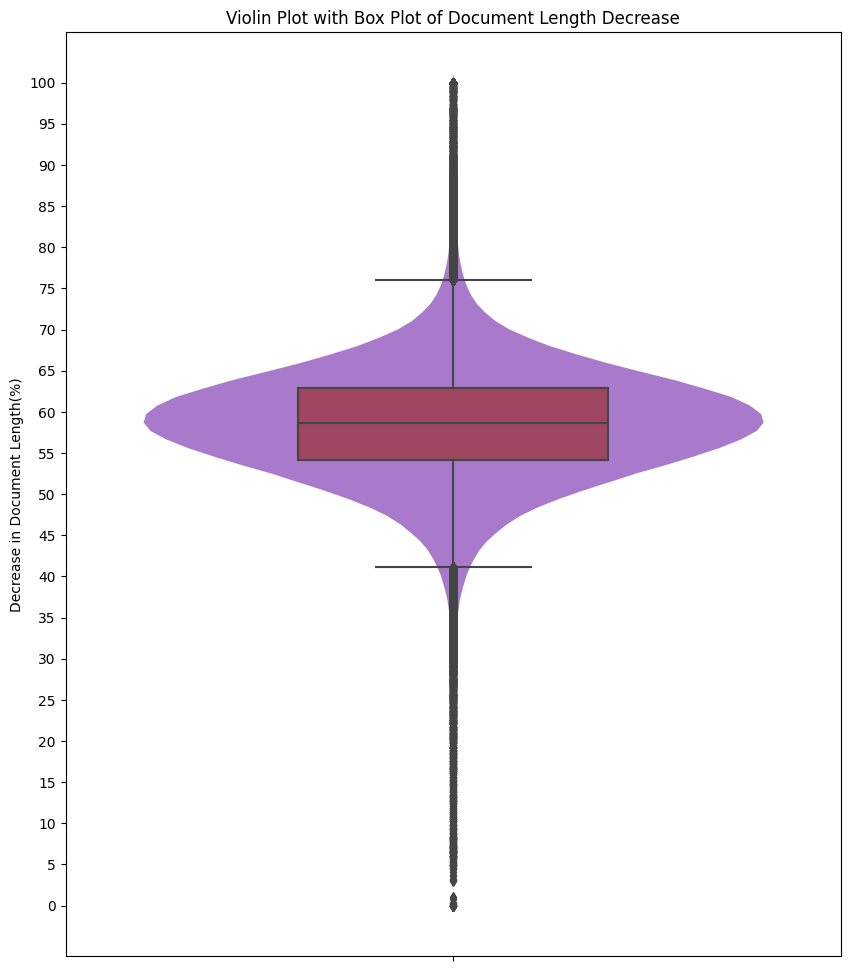

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

ax = sns.violinplot(data=combined, y='Percentage Decrease', color="#af52f4", inner=None, linewidth=0, saturation=0.5)
sns.boxplot(data=combined, y='Percentage Decrease', saturation=0.5, width=0.4,
            palette='rocket', boxprops={'zorder': 2}, ax=ax)

plt.ylabel("Decrease in Document Length(%)")

y_ticks = range(0, 105, 5)
plt.yticks(y_ticks)

plt.title("Violin Plot with Box Plot of Document Length Decrease")
plt.show()

In [ ]:
# Calculate Boxplot stats
Q1 = combined['Percentage Decrease'].quantile(0.25)
Q2 = combined['Percentage Decrease'].quantile(0.50)
Q3 = combined['Percentage Decrease'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

print(f"Upper Limit: {upper}")
print(f"Q3 (75th Percentile): {Q3}")
print(f"Q2 (50th Percentile/Median): {Q2}")
print(f"Q1 (25th Percentile): {Q1}")

Upper Limit: 76.02940994580807
Q3 (75th Percentile): 62.92707802141765
Q2 (50th Percentile/Median): 58.66013071895425
Q1 (25th Percentile): 54.19219007182404


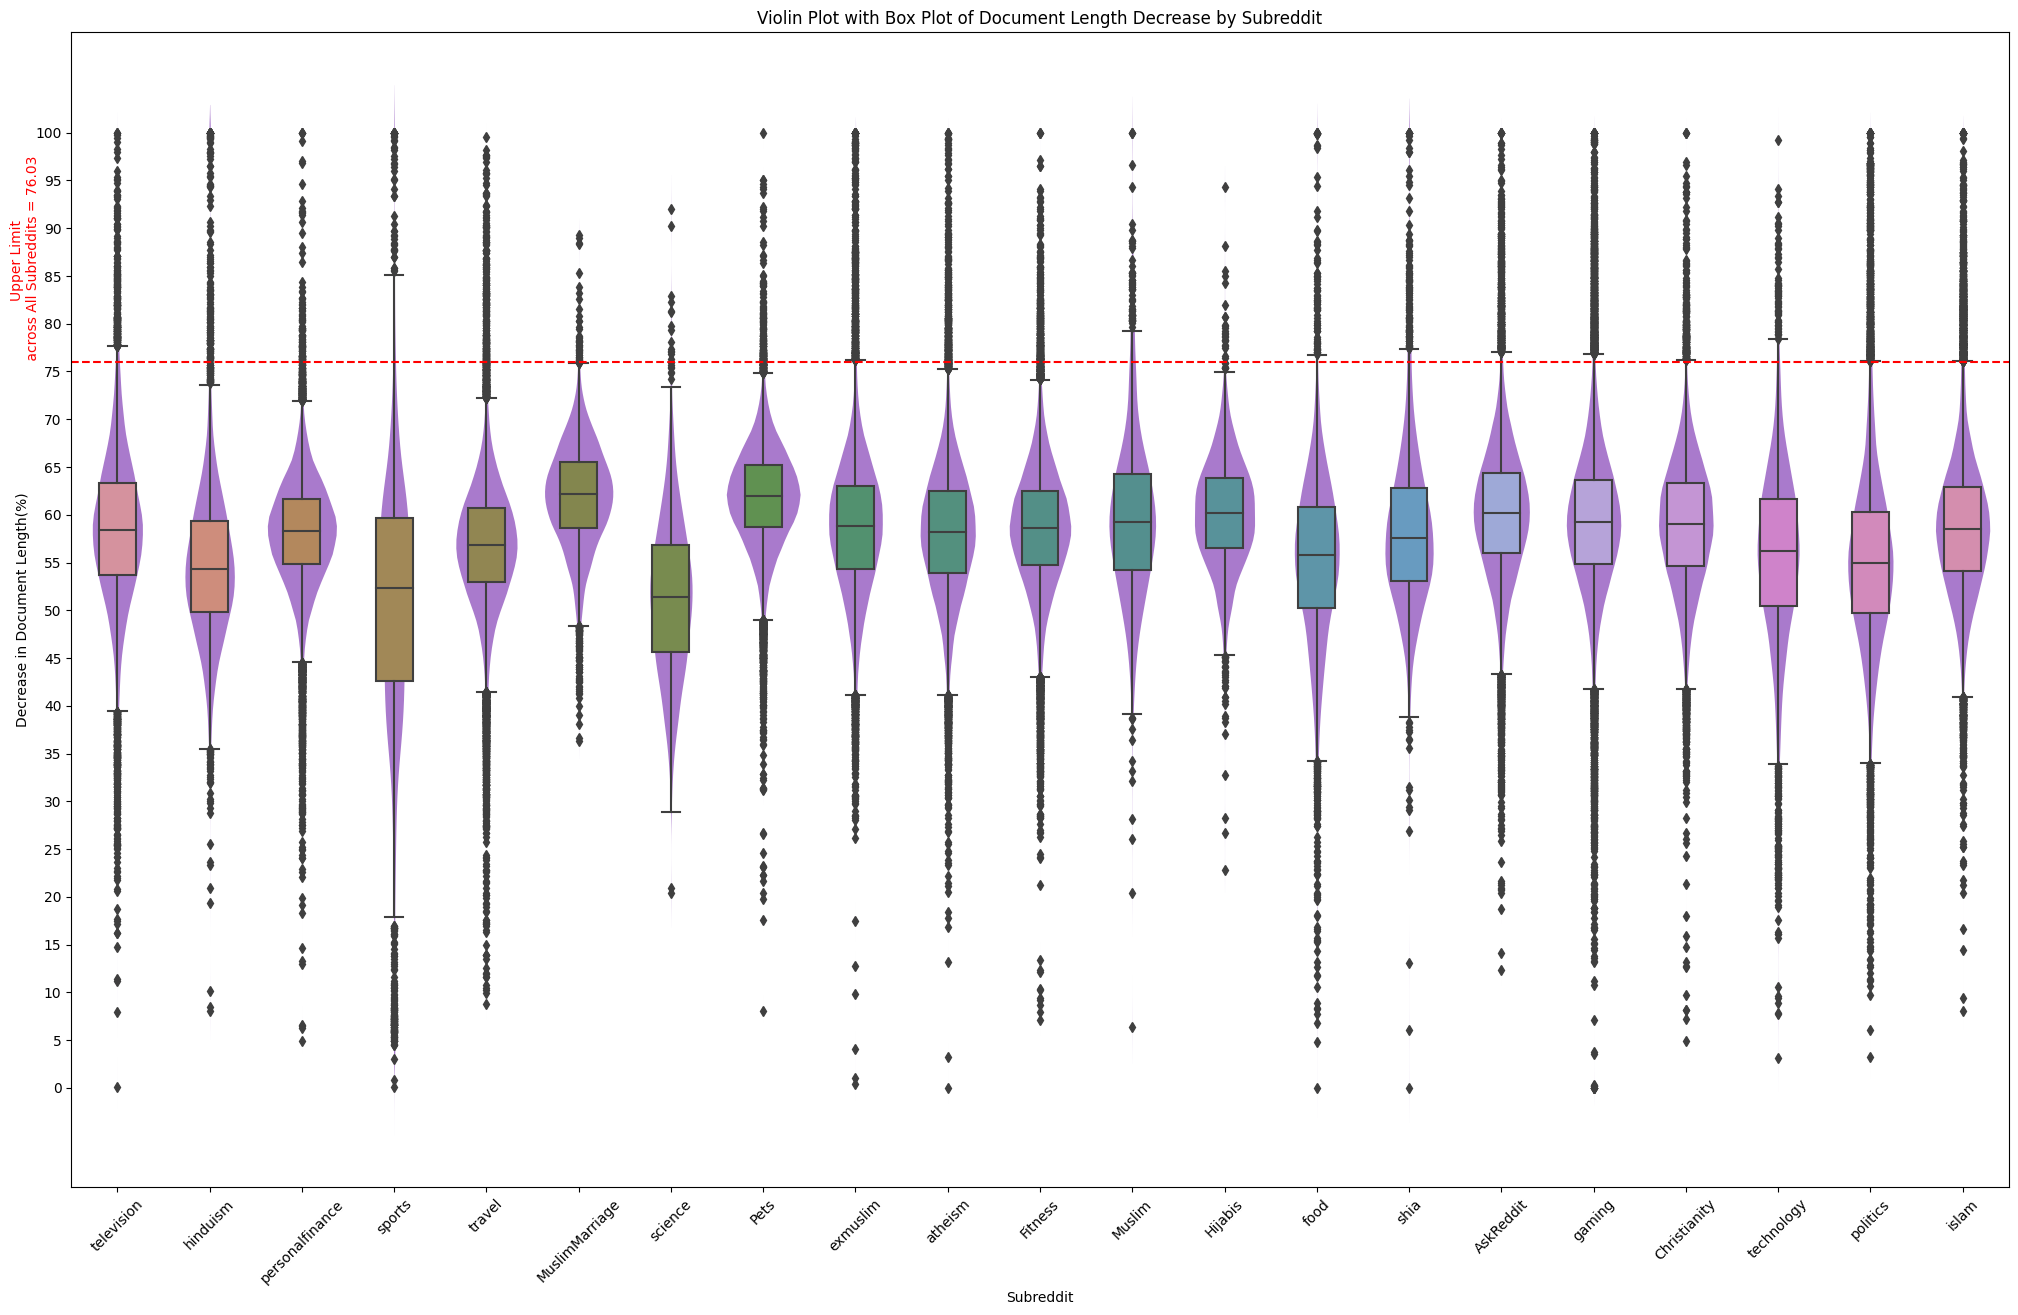

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 15))

ax = sns.violinplot(data=combined, x='subreddit', y='Percentage Decrease', color="#af52f4", inner=None, linewidth=0, saturation=0.5)
sns.boxplot(data=combined, x='subreddit', y='Percentage Decrease', saturation=0.5, width=0.4,
            palette='husl', boxprops={'zorder': 2}, ax=ax)

plt.xlabel("Subreddit")
plt.ylabel("Decrease in Document Length(%)")
plt.title("Violin Plot with Box Plot of Document Length Decrease by Subreddit")

y_value = upper
plt.axhline(y=y_value, color='red', linestyle='--')
plt.text(-1, y_value, f'Upper Limit\n across All Subreddits = {y_value:.2f}', color='red', fontsize=10, rotation='vertical', ha="center")

y_ticks = range(0, 105, 5)
plt.yticks(y_ticks)
plt.xticks(rotation=45)

plt.show()

#Storing the High Quality Documents

In [11]:
# Only use documents <= 2791 chars and >=500 chars and percentage decrease <=76%
finaldf = combined[(combined["Original Document"].str.len()<=2791) & (combined["Original Document"].str.len()>=500) & (combined["Percentage Decrease"]<=76)][["Original Document", "subreddit"]]
finaldf.columns=["Document", "subreddit"]
finaldf

,Document,subreddit
0,If the last five years of television should ha...,television
1,The title says it all. I'm a bit miffed but a...,television
2,Robert Englund played the lovable I-can't-beli...,television
3,Hope it's OK to ask here...\n\nI changed from ...,television
4,you get 3 hrs/day during the week and 1 hr on ...,television
...,...,...
589563,I made a similar post earlier in r/askmuslims ...,islam
589564,"Salam, the title is pretty self explanatory, b...",islam
589565,This is more of an emotional rather than a rat...,islam
589566,"salaam,\n\nmy father died last year and my mom...",islam


In [12]:
#finaldf.to_csv("/content/drive/MyDrive/FYP/Data/Annotation Data/Quality-Docs.csv", index=False)

# Must be read like this
# pd.read_csv("/content/drive/MyDrive/FYP/Data/Annotation Data/Quality-Docs.csv",lineterminator='\n')